# Multisensor rail detection in automatic train operations - Baselining on train set

Attila Kovacs
25.11.2023


## Introduction

In this notebeook, we will do further feature extraction on the base of which the baseline results will be generated.
In the following only the train data will be used.

## Load required packages and dataset

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from utils import apply_fast_line_detection
from glob import glob
import os
import pandas as pd
import seaborn as sns
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
from utils import print_image, apply_fast_line_detection, q10, q1, q5, q90, q95,q99


%matplotlib inline

DB_PATH = "./orig_data/DB/"


In [3]:
latest_split = max(glob("./dataframe_dumps/df_split_*"), key=os.path.getmtime)
df = pd.read_csv(latest_split, index_col=0)
latest_split

'./dataframe_dumps\\df_split_10-02-2023_16-01-24.csv'

In [4]:
# reformat from string to np array
df["poly2d"] = df["poly2d"].apply(
    lambda x: np.fromstring(x.replace("[", "").replace("]", ""), sep=",")
    .reshape((-1, 2))
    .astype(np.int32)
)

In [6]:
# apply feature extraction only on train set
df = df[df["set"] == "train"]


df.head()

longitude   latitude                        tag   type  \
0   9.797191  53.581087  10_station_suelldorf_10.1  track   
1   9.797191  53.581087  10_station_suelldorf_10.1  track   
2   9.797191  53.581087  10_station_suelldorf_10.1  track   
3   9.797191  53.581087  10_station_suelldorf_10.1  track   
4   9.797191  53.581087  10_station_suelldorf_10.1  track   

                             object_uid                               name  \
0  37706a45-6aa3-4e9d-ad0d-91b2bb459b1a           ir_center__poly2d__track   
1  37706a45-6aa3-4e9d-ad0d-91b2bb459b1a           ir_center__poly2d__track   
2  37706a45-6aa3-4e9d-ad0d-91b2bb459b1a          rgb_center__poly2d__track   
3  37706a45-6aa3-4e9d-ad0d-91b2bb459b1a          rgb_center__poly2d__track   
4  37706a45-6aa3-4e9d-ad0d-91b2bb459b1a  rgb_highres_center__poly2d__track   

                              label_uid              sensor  height  width  \
0  098ae65d-7bfe-4556-aa0c-39b07d5988ca           ir_center     480    640   
1  bed7c04d-3fe7-4b96-b40a-30179bdaa9e8           ir_center     480    640   
2  a2b91a0b-6677-4c7f-a273-974e1e35b85d          rgb_center    1600   2464   
3  92d45536-139f-4a54-a1db-b828ce1c261d          rgb_center    1600   2464   
4  a07b68eb-56be-4b3f-ade9-320f395ea238  rgb_highres_center    2504   4112   

   ... label_type closed                                                val  \
0  ...     poly2d  False  [180.4612434726, 474.2434782609, 177.119206919...   
1  ...     poly2d  False  [357.5891808094, 475.0782608696, 309.965159921...   
2  ...     poly2d  False  [945.0403950013, 1599.0, 992.3449231127, 1441....   
3  ...     poly2d  False  [1512.7574247891, 1597.5621662363, 1388.928921...   
4  ...     poly2d  False  [1377.0407890837, 2503.0, 1462.1360417168, 219...   

  occlusion   railSide                                             poly2d  \
0   75-99 %   leftRail  [[180, 474], [177, 426], [169, 367], [159, 324...   
1    0-25 %  rightRail  [[357, 475], [309, 383], [275, 334], [250, 293...   
2    0-25 %   leftRail  [[945, 1599], [992, 1441], [1007, 1385], [1024...   
3    0-25 %  rightRail  [[1512, 1597], [1388, 1335], [1338, 1244], [12...   
4    0-25 %   leftRail  [[1377, 2503], [1462, 2197], [1546, 1877], [16...   

  sensor_short x_max_polyline y_max_polyline    set  
0       center       0.190625       0.806250  train  
1       center       0.431250       0.825000  train  
2       center       0.004058       0.480625  train  
3       center       0.227273       0.480000  train  
4       center       0.048638       0.841054  train  

[5 rows x 23 columns]

## Analyzing label formats (i.e., orientation of the tracks in the images)

In order to understand which type of shapes are learned by the deep learning model, we analyze the orientation of the tracks (e.g., vertical, horizontal, diagonal).
Therefore, for each polyline we generate a bounding box. The format and size of the bounding bounding boxes given an indication of how the tracks are oriented in the image. However, this approach does not state whether the tracks are curved or straight (examples are given below).
The changes in the respective coordinates are scaled between 0 and 1 to account for different image sizes. Additionally, the features will support the baselining approach.

The figure below gives the histogram of the height and width of the bounding boxes for each orientation of the sensor.
In the images with a center orientation, it can be seen that most tracks are vertically oriented, e.g. the bounding boxes are higher than wide. There is only a very low number of bounding boxes that are almost as wide as the image.
In the left and right oriented sensors, we can see that many bounding boxes span over the entire image horizontally, whereas the number of high and slim bounding boxes is lower than in the center oriented sensors.
Independently of the sensor, there is a large number of images with very small bounding boxes (see lower left corner of plots).


C:\Users\atkovacs\AppData\Local\Temp\ipykernel_376\131241791.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  _ = fig.show()


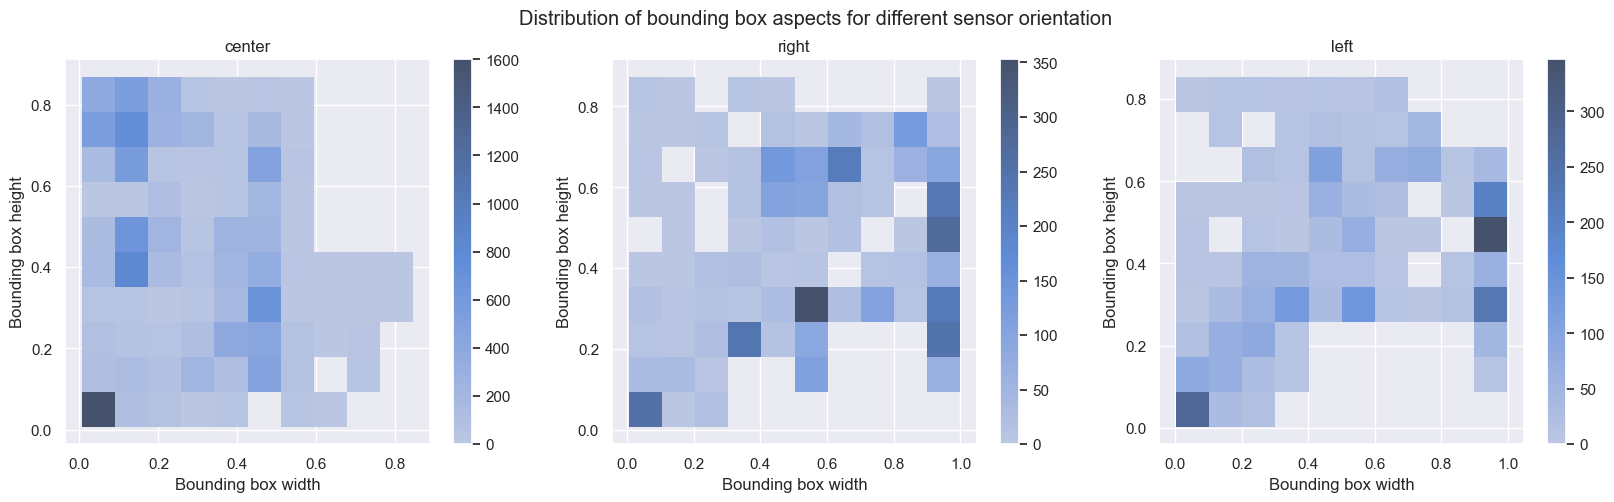

In [7]:
sns.set(rc={"figure.figsize": (20, 5)})

# select only the orientation of the sensor
df["sensor_short"] = df["sensor"].apply(lambda x: x.split("_")[-1])

df["bb_width"] = df.apply(
    lambda x: (max([i[0] for i in x.poly2d]) - min([i[0] for i in x.poly2d])) / x.width,
    axis=1,
)

df["bb_height"] = df.apply(
    lambda x: (max([i[1] for i in x.poly2d]) - min([i[1] for i in x.poly2d]))
    / x.height,
    axis=1,
)

# plot
number_plots = len(df["sensor_short"].unique())
fig, ax = plt.subplots(1, number_plots)
fig.suptitle("Distribution of bounding box aspects for different sensor orientation")
for idx, s in enumerate(df["sensor_short"].unique()):
    df_plot = df[df["sensor_short"] == s]
    sns.histplot(
        x=df_plot["bb_width"],
        y=df_plot["bb_height"],
        ax=ax[idx],
        cbar=True,
        bins=10,
    ).set(title=s, xlabel="Bounding box width", ylabel="Bounding box height")

_ = fig.show()

#### Examples: narrow and high bounding boxes

The track labels are vertically oriented but might be curved or start end at the border of the image. 

In [8]:
df_temp = df[["bb_width", "bb_height", "path", "label_uid"]].sort_values(
    ["bb_height", "bb_width"], ascending=[False, True]
)
df_temp.head()

bb_width  bb_height                                               path  \
20448  0.083901   0.873403  7_approach_underground_station_7.1/rgb_highres...   
20473  0.150535   0.873003  7_approach_underground_station_7.1/rgb_highres...   
20486  0.095331   0.870208  7_approach_underground_station_7.1/rgb_highres...   
20511  0.156858   0.869808  7_approach_underground_station_7.1/rgb_highres...   
20524  0.084874   0.869010  7_approach_underground_station_7.1/rgb_highres...   

                                  label_uid  
20448  746f9d75-3e6c-4a59-a7c6-ddfa63507421  
20473  921133c9-933d-45e8-903e-e5040765c28c  
20486  9957be4f-a572-4780-b502-0cc72ae483c9  
20511  61aa72ba-b12d-4b4d-84f5-4d5daa3b70bc  
20524  9d7d3669-faf2-4861-8f31-810d9c0e4842

7_approach_underground_station_7.1/rgb_highres_right/154_1631705118.500000000.png


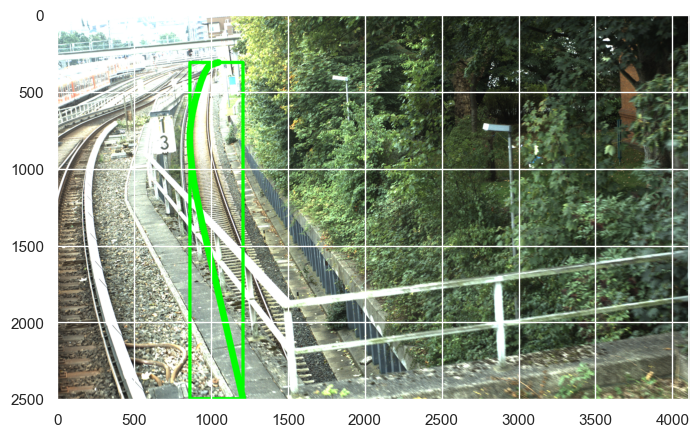

In [9]:
file = df_temp.iloc[0]["path"]
uid = df_temp.iloc[0]["label_uid"]
print_image(
    df[df["label_uid"] == uid],
    file=file,
    path=DB_PATH,
    include_bounding_box=True,
    include_polyline=True,
)

10_station_suelldorf_10.1/ir_center/219_1631703821.000464480.png


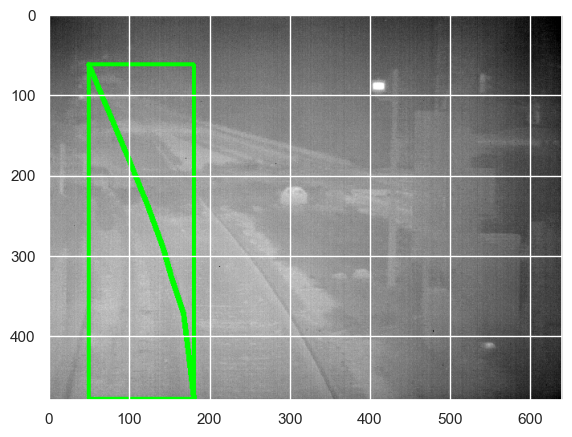

In [10]:
file = df_temp.iloc[5]["path"]
uid = df_temp.iloc[5]["label_uid"]
print_image(
    df[df["label_uid"] == uid],
    file=file,
    path=DB_PATH,
    include_bounding_box=True,
    include_polyline=True,
)

#### Examples: wide and low bounding boxes

The track labels are horizontally oriented. 

In [11]:
df_temp = df[["bb_width", "bb_height", "path", "label_uid"]].sort_values(
    ["bb_width", "bb_height"], ascending=[False, True]
)
df_temp.head()

bb_width  bb_height                                               path  \
18293  0.999757   0.220847  5_station_bergedorf_5.1/rgb_highres_right/076_...   
18294  0.999757   0.221645  5_station_bergedorf_5.1/rgb_highres_right/076_...   
18332  0.999757   0.223243  5_station_bergedorf_5.1/rgb_highres_right/077_...   
18369  0.999757   0.223243  5_station_bergedorf_5.1/rgb_highres_right/078_...   
18160  0.999757   0.227636  5_station_bergedorf_5.1/rgb_highres_right/072_...   

                                  label_uid  
18293  f676f09b-a13b-4bc6-aa1b-82e85c552200  
18294  aa0cbbae-a8fc-4413-8b55-2fab94a79343  
18332  2cd3b2dc-313f-4219-8a2e-218b3a5409f6  
18369  eff822a8-b81f-456e-be42-729ec9702444  
18160  29e10c43-ddf6-4f0c-959e-6bc802358773

5_station_bergedorf_5.1/rgb_highres_right/076_1631529900.700000016.png


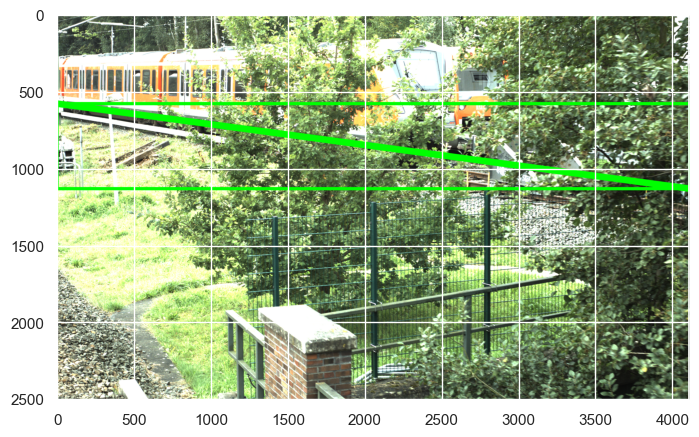

In [12]:
file = df_temp.iloc[0]["path"]
uid = df_temp.iloc[0]["label_uid"]
print_image(
    df[df["label_uid"] == uid],
    file=file,
    path=DB_PATH,
    include_bounding_box=True,
    include_polyline=True,
)

3_fire_site_3.1/rgb_highres_left/043_1631639435.400000017.png


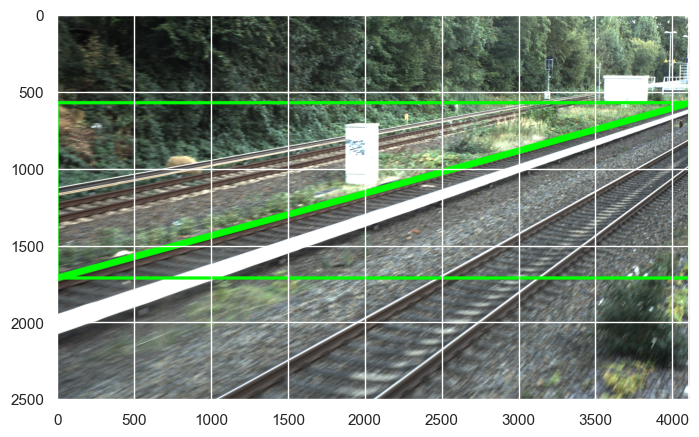

In [13]:
file = df_temp.iloc[120]["path"]
uid = df_temp.iloc[120]["label_uid"]
print_image(
    df[df["label_uid"] == uid],
    file=file,
    path=DB_PATH,
    include_bounding_box=True,
    include_polyline=True,
)

#### Examples: narrow and low bounding boxes

Track labels that are very small (labels are small green marks at the edge of the images).  

In [14]:
df_temp = df[["bb_width", "bb_height", "path", "label_uid"]].sort_values(
    ["bb_width", "bb_height"], ascending=[True, True]
)
df_temp.head()

bb_width  bb_height                                               path  \
19545  0.001702   0.019169  6_station_klein_flottbek_6.1/rgb_highres_left/...   
19132  0.002189   0.002796  5_station_bergedorf_5.1/rgb_highres_left/097_1...   
20525  0.005276   0.007500  7_approach_underground_station_7.1/rgb_right/1...   
19522  0.005350   0.019968  6_station_klein_flottbek_6.1/rgb_highres_left/...   
19174  0.005837   0.009185  5_station_bergedorf_5.1/rgb_highres_left/098_1...   

                                  label_uid  
19545  cdec5659-4833-456c-ab2c-9ff19b6ac9a7  
19132  6ade21c7-54f2-407a-b999-06550da89b23  
20525  98f96098-2a03-4a70-9949-2851063c40ca  
19522  b6050915-b1ba-4bd2-bcf7-b99dd2bfb7a7  
19174  c51325b9-06a5-4b38-800b-24f43c2a7c17

6_station_klein_flottbek_6.1/rgb_highres_left/023_1631704638.400000022.png


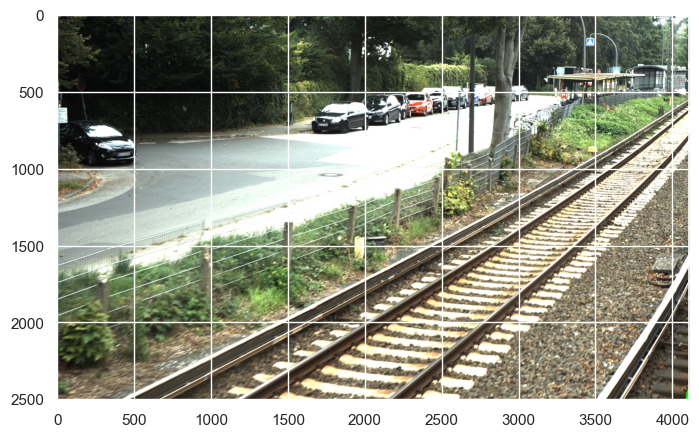

In [15]:
file = df_temp.iloc[0]["path"]
uid = df_temp.iloc[0]["label_uid"]
print_image(
    df[df["label_uid"] == uid],
    file=file,
    path=DB_PATH,
    include_bounding_box=True,
    include_polyline=True,
)

5_station_bergedorf_5.1/rgb_highres_left/049_1631529898.000000019.png


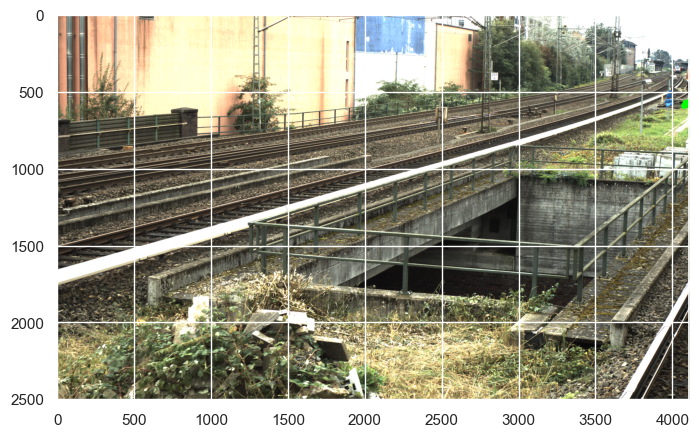

In [16]:
file = df_temp.iloc[25]["path"]
uid = df_temp.iloc[25]["label_uid"]
print_image(
    df[df["label_uid"] == uid],
    file=file,
    path=DB_PATH,
    include_bounding_box=True,
    include_polyline=True,
)

#### Examples: wide and high bounding boxes

The track labels are diagonally oriented. 

In [17]:
df_temp = df[["bb_width", "bb_height", "path", "label_uid"]].sort_values(
    ["bb_width", "bb_height"], ascending=[False, False]
)
df_temp.head()

bb_width  bb_height                                               path  \
25943  0.999757   0.685703  9_station_ruebenkamp_9.3/rgb_highres_right/219...   
25975  0.999757   0.683706  9_station_ruebenkamp_9.3/rgb_highres_right/220...   
26005  0.999757   0.683307  9_station_ruebenkamp_9.3/rgb_highres_right/221...   
26035  0.999757   0.679313  9_station_ruebenkamp_9.3/rgb_highres_right/222...   
26065  0.999757   0.678914  9_station_ruebenkamp_9.3/rgb_highres_right/223...   

                                  label_uid  
25943  d13d5a6a-c14f-43ff-87bf-5464c701d32c  
25975  f1da21d8-a573-4c08-8835-6e3411141471  
26005  20902e40-9e1c-4908-b22b-67a027759995  
26035  6a1053fd-af2e-4981-98fc-2cd5934429e2  
26065  52fa9f63-614e-439d-8238-b549b3354531

9_station_ruebenkamp_9.3/rgb_highres_right/219_1631712689.500000015.png


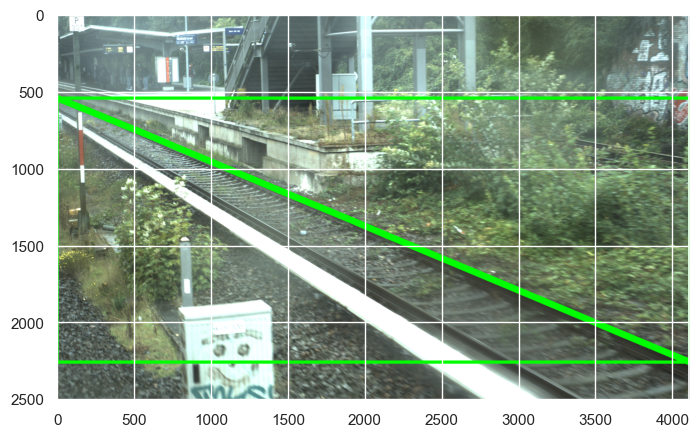

In [18]:
file = df_temp.iloc[0]["path"]
uid = df_temp.iloc[0]["label_uid"]
print_image(
    df[df["label_uid"] == uid],
    file=file,
    path=DB_PATH,
    include_bounding_box=True,
    include_polyline=True,
)

7_approach_underground_station_7.3/rgb_highres_left/069_1631705238.000000012.png


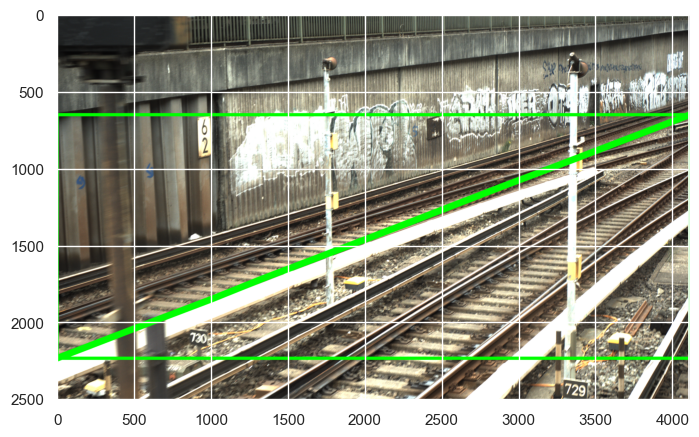

In [19]:
file = df_temp.iloc[20]["path"]
uid = df_temp.iloc[20]["label_uid"]
print_image(
    df[df["label_uid"] == uid],
    file=file,
    path=DB_PATH,
    include_bounding_box=True,
    include_polyline=True,
)

## Analyzing aspect ratios of bounding boxes by orientation of cameras

In [20]:
df["bb_aspect_ratio"] = df.apply(lambda x: x.bb_width / x.bb_height, axis=1)

C:\Users\atkovacs\AppData\Local\Temp\ipykernel_376\4212947757.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  _ = fig.show()


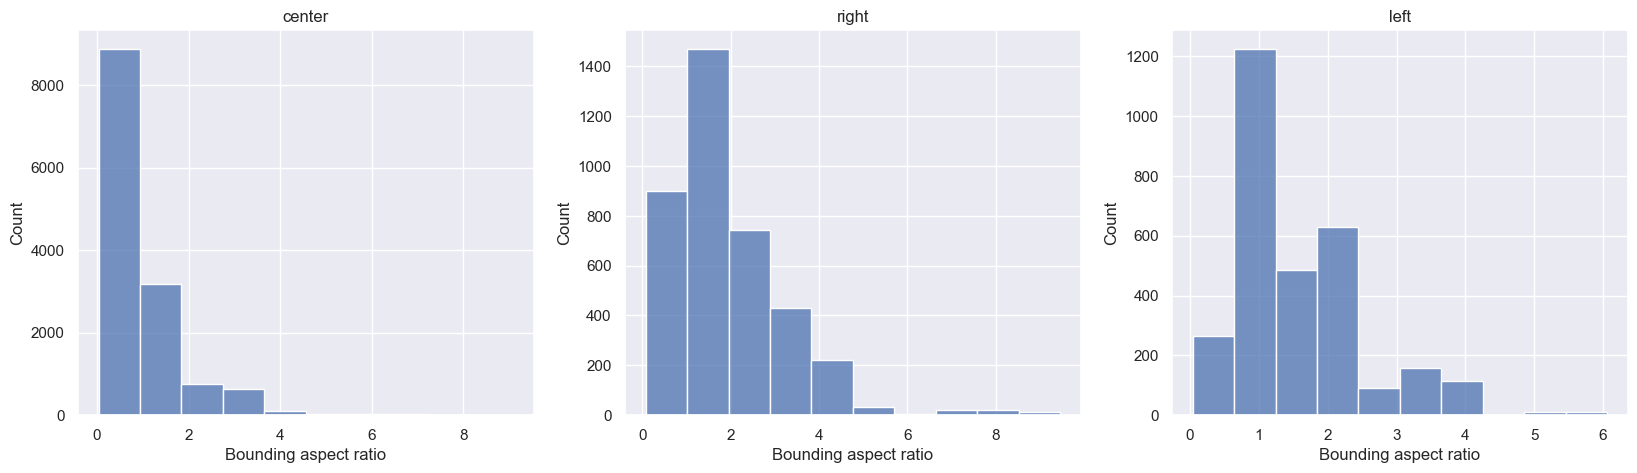

In [21]:
# plot
number_plots = len(df["sensor_short"].unique())
fig, ax = plt.subplots(1, number_plots)
for idx, s in enumerate(df["sensor_short"].unique()):
    df_plot = df[df["sensor_short"] == s]
    sns.histplot(
        x=df_plot["bb_aspect_ratio"],
        ax=ax[idx],
        cbar=True,
        bins=10,
    ).set(title=s, xlabel="Bounding aspect ratio", ylabel="Count")

_ = fig.show()

[Text(0.5, 1.0, 'Bounding box aspect ratios'),
 Text(0, 0.5, 'Bounding aspect ratio'),
 Text(0.5, 0, 'Sensor')]

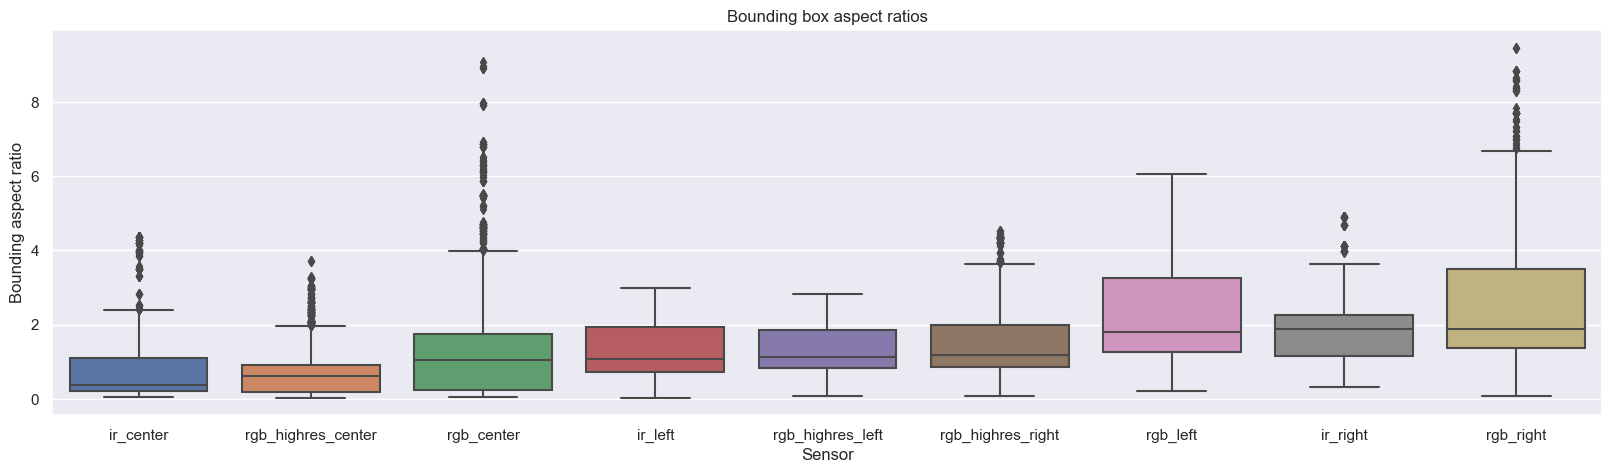

In [22]:
order = df.groupby(by=["sensor"])["bb_aspect_ratio"].median().sort_values().index


sns.boxplot(df, x=df["sensor"].sort_values(), y=df["bb_aspect_ratio"], order=order).set(
    title="Bounding box aspect ratios", ylabel="Bounding aspect ratio", xlabel="Sensor"
)

## Prepare baselining

Baselining will be performed by a non-ai approach for image processing. In particular, we will use the fast line detecition implenetation of open images.
In this notebook, we demonstrate only the underlying idea.

The experiments will be performed in seperate python scripts that run in parallel.


### Calculate quntiles for the bounding boxes of the labels

In [23]:
df_sensor_bb = (
    df.groupby(["sensor"])
    .agg({"bb_aspect_ratio": [np.mean, np.median, q1, q5, q95, q10, q90, q99]})
    .reset_index()
)
df_sensor_bb.columns = df_sensor_bb.columns.droplevel()
df_sensor_bb = df_sensor_bb.rename(columns={"": "sensor"})
df_sensor_bb

sensor      mean    median        q1        q5       q95  \
0           ir_center  0.714158  0.379167  0.104303  0.113281  2.209924   
1             ir_left  1.215116  1.081721  0.121008  0.344118  2.315217   
2            ir_right  1.848743  1.872070  0.422788  0.813253  3.398936   
3          rgb_center  1.283308  1.056786  0.126889  0.208074  3.541611   
4  rgb_highres_center  0.670795  0.617689  0.066481  0.070636  1.803567   
5    rgb_highres_left  1.319509  1.120366  0.138148  0.654107  2.192111   
6   rgb_highres_right  1.622703  1.190969  0.168922  0.607235  3.626738   
7            rgb_left  2.150740  1.815115  0.353007  0.699807  3.881919   
8           rgb_right  2.521643  1.890448  0.143088  0.950690  5.515002   

        q10       q90       q99  
0  0.126283  1.856707  3.916667  
1  0.451462  2.293062  2.591151  
2  1.000155  2.687500  4.830855  
3  0.232127  3.085137  5.487203  
4  0.072688  1.561434  2.620135  
5  0.738129  2.180654  2.578114  
6  0.690459  3.580122  4.323646  
7  0.872565  3.844593  5.631558  
8  1.328575  4.100899  8.475703

In [23]:
# df_sensor_bb.to_csv(
#     "../rail_detection/baselining/bounding_box_aspect_ratios.csv", index=False
# )

### Select samples for performing the parameter tuning for the baselining approach

As many frames or images are similar in a video sequence, we select only one image per sequence to perform the parameter tuning on. 

In [24]:
df_sample = df.groupby(["tag", "sensor"], as_index=False)[
    ["tag", "sensor", "path"]
].sample(n=1)
df_sample

tag              sensor  \
54     10_station_suelldorf_10.1           ir_center   
110    10_station_suelldorf_10.1          rgb_center   
35     10_station_suelldorf_10.1  rgb_highres_center   
127         11_main_station_11.1           ir_center   
147         11_main_station_11.1          rgb_center   
...                          ...                 ...   
27227   9_station_ruebenkamp_9.7            ir_right   
27210   9_station_ruebenkamp_9.7          rgb_center   
27365   9_station_ruebenkamp_9.7  rgb_highres_center   
27114   9_station_ruebenkamp_9.7   rgb_highres_right   
27183   9_station_ruebenkamp_9.7           rgb_right   

                                                    path  
54     10_station_suelldorf_10.1/ir_center/220_163170...  
110    10_station_suelldorf_10.1/rgb_center/225_16317...  
35     10_station_suelldorf_10.1/rgb_highres_center/2...  
127    11_main_station_11.1/ir_center/277_1631531579....  
147    11_main_station_11.1/rgb_center/280_1631531580...  
...                                                  ...  
27227  9_station_ruebenkamp_9.7/ir_right/070_16317195...  
27210  9_station_ruebenkamp_9.7/rgb_center/070_163171...  
27365  9_station_ruebenkamp_9.7/rgb_highres_center/07...  
27114  9_station_ruebenkamp_9.7/rgb_highres_right/066...  
27183  9_station_ruebenkamp_9.7/rgb_right/069_1631719...  

[196 rows x 3 columns]

In [25]:
# df_sample.to_csv("../rail_detection/baselining/image_sample.csv", index=False)

### Demo of fast line detection approach

#### Select image and respective label bounding box quantiles

In [27]:
temp = df.sample(1)

path = "./orig_data/DB/" + temp["path"].values[0]
max_aspect_ratio = df_sensor_bb.loc[
    df_sensor_bb.sensor == temp["sensor"].values[0],
    df_sensor_bb.columns == "q90",
].values[0][0]
min_aspect_ratio = df_sensor_bb.loc[
    df_sensor_bb.sensor == temp["sensor"].values[0],
    df_sensor_bb.columns == "q10",
].values[0][0]
print(path)
print(min_aspect_ratio)
print(max_aspect_ratio)

./orig_data/DB/3_fire_site_3.4/rgb_highres_center/097_1631640361.800000021.png
0.07268786990516166
1.561433990707678


#### Run fast line detection algorithm

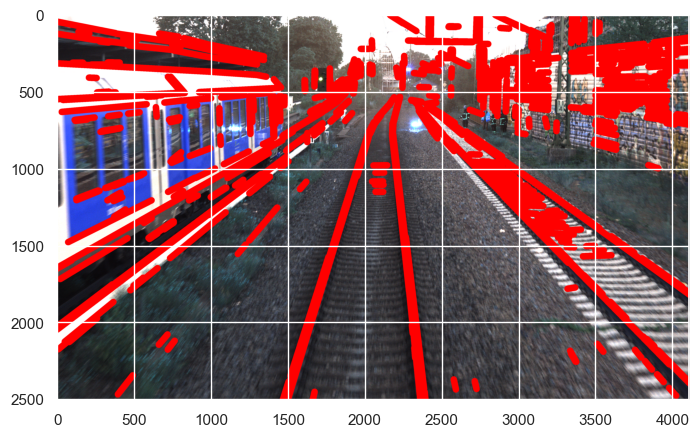

In [29]:
mask = apply_fast_line_detection(
    path,
    kernel_size=0,
    length_treshold=50,
    max_aspect_ration=10000000,
    min_aspect_ration=0,
)

#### Remove lines that are outside the bounding box ratios

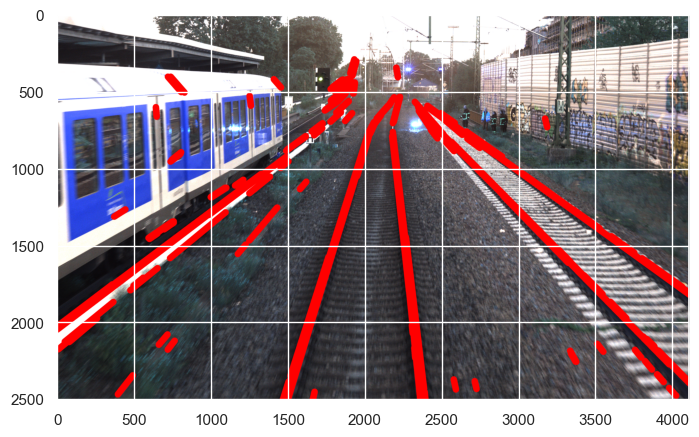

In [31]:
mask = apply_fast_line_detection(
    path,
    kernel_size=0,
    length_treshold=50,
    max_aspect_ration=max_aspect_ratio,
    min_aspect_ration=min_aspect_ratio,
)

#### Generate mask

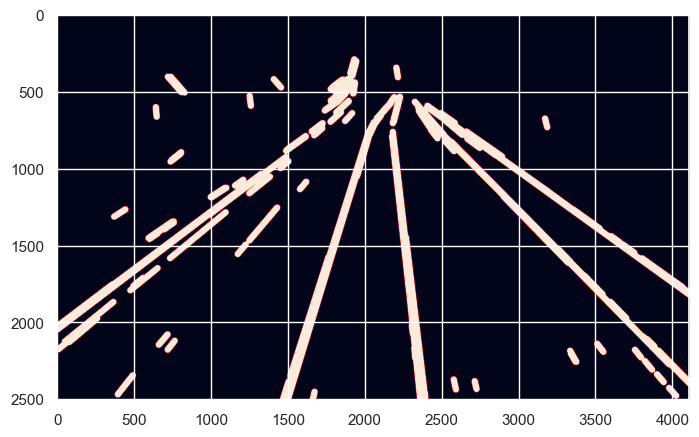

In [32]:
plt.imshow(mask)

#### Remove noise

In [33]:
def remove_noise(mask, treshold):
    """
    remove noise, i.e., small elements from mask
    """
    if treshold < 1e-5 or mask.max() < 1e-5:
        return mask
    white = mask.max()
    assert white == 1 or white == 255, "white value neither 1 nor 255"
    if white == 1:
        nb_blobs, im_with_separated_blobs, stats, _ = cv2.connectedComponentsWithStats(
            (mask * 255).astype(np.uint8)
        )
        im_with_separated_blobs = im_with_separated_blobs / 255
    else:
        nb_blobs, im_with_separated_blobs, stats, _ = cv2.connectedComponentsWithStats(
            mask
        )

    sizes = stats[:, -1]
    sizes = sizes[1:]
    sizes = sizes / sizes.max()
    nb_blobs -= 1
    im_result = np.zeros_like(im_with_separated_blobs)
    for blob in range(nb_blobs):
        if sizes[blob] >= treshold:
            im_result[im_with_separated_blobs == blob + 1] = white
    return im_result

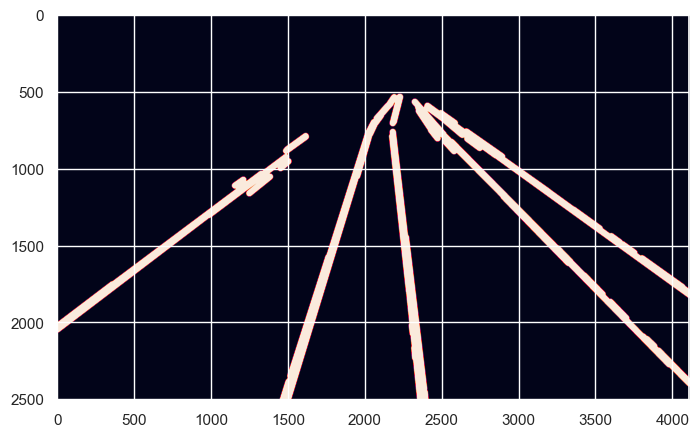

In [38]:
img_noise = remove_noise(mask=mask, treshold=0.2)
plt.imshow(img_noise)